# Plot stats of dv/v model parameters with MCMC.

2023.4.4 Kurama Okubo

Plot master figures of MCMC inversion.

2023.4.18 update to get fixed paramters.

In [46]:
# %load_ext autoreload
# %autoreload 2

import datetime
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
%matplotlib inline
from IPython.display import display, Math

import numpy as np
import pandas as pd
import h5py
import pickle

import shutil
from tqdm import tqdm
import glob

import matplotlib as mpl

import emcee # MCMC sampler
import corner

# import mcmc functions
from scattermatrix import *
from MCMC_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

# Plot all dv/v fitting time history

In [47]:
# load the data
dvvmethod = "stretching"
modelcase = "wlin"

modelparam_indir = "../modelparam_data"
freqband = "0.9-1.2"

residu_absmean_thresh = 0.05
residu_var_thresh = 0.002

outputdatadir = "../data_stats"
output_imgdir = "../figure_stats"

if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)
    
if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)


In [48]:
# search the modelparam files
fi_list = glob.glob(modelparam_indir+f"/MCMC_modelparam_*_{dvvmethod}_{freqband}Hz_{modelcase}.pickle")

In [49]:
meta_dict = dict()
dvv_dict = dict()

# store meta data
meta_dict["dvvmethod"] = dvvmethod
meta_dict["modelcase"] = modelcase
meta_dict["freqband"] = freqband

if meta_dict["modelcase"] == "base":
    meta_dict["ndim"] = 12
elif meta_dict["modelcase"] == "wlin":
    meta_dict["ndim"] = 13
else:
    print("model case not known.")
    
meta_dict["modelkeys"] = get_keys(meta_dict["modelcase"])
# read metadata

finame_meta = fi_list[0]
with open(finame_meta, 'rb') as fi:
    modelparam = pickle.load(fi)
    meta_dict["unix_tvec"] = modelparam["unix_tvec"]
    meta_dict["uniform_tvec"] = modelparam["uniform_tvec"]
    meta_dict["fitting_period_ind"] = modelparam["fitting_period_ind"]
    meta_dict["unix_tSS"] = modelparam["unix_tSS"]
    meta_dict["unix_tPF"] = modelparam["unix_tPF"]
    
meta_dict.keys()

dict_keys(['dvvmethod', 'modelcase', 'freqband', 'ndim', 'modelkeys', 'unix_tvec', 'uniform_tvec', 'fitting_period_ind', 'unix_tSS', 'unix_tPF'])

In [50]:
# read dv/v data and compute the model using best model parameters
stationpair_list=[]

for finame in fi_list:

    stationpair = os.path.basename(finame).split("_")[2]
    stationpair_list.append(stationpair)
    
    with open(finame, 'rb') as fi:
        modelparam_st = pickle.load(fi)
        modelparam_st["fixparam01"] = False
        dvv_dict[stationpair+"/dvv_data"] = modelparam_st["dvv_data"]
        dvv_dict[stationpair+"/err_data"] = modelparam_st["err_data"]
        dvv_dict[stationpair+"/maxlnprob_theta"] = modelparam_st["maxlnprob_theta"]

        # compute the model
        if meta_dict["modelcase"] == "base":    
            dvv_model = model_base(modelparam_st["maxlnprob_theta"], all=False, **modelparam_st)

        elif meta_dict["modelcase"] == "wlin":
            dvv_model = model_wlin(modelparam_st["maxlnprob_theta"], all=False, **modelparam_st)

        dvv_dict[stationpair+"/dvv_model"] = dvv_model

In [51]:
# plt.plot(modelparam_st["uniform_tvec"], modelparam_st["precip"], "r-" )
# plt.plot(modelparam_st["uniform_tvec"], modelparam_st["CAVG"], "b-" )

# Compute residuals, AIC and BIC

In [52]:
# make a dataframe to store the model parameters and AIC, BIC
df_dvvstats_all = pd.DataFrame(columns=["dvvmethod", "modelcase", "freqband",  'a0', 'p1', 'a_{precip}', 'p2', 't_{shiftdays}',
                'S1', 'log10tmin1', 'log10tmax1', 'S2', 'log10tmin2','log10tmax2', 'b_{lin}', 'logf', 'AIC', 'BIC', 'residu_absmean', 'residu_var'])

for st in np.sort(stationpair_list):
    # st = stationpair_list[21]

    dvv_data = dvv_dict[st+"/dvv_data"]
    dvv_model = dvv_dict[st+"/dvv_model"]
    maxlnprob_theta = dvv_dict[st+"/maxlnprob_theta"]

    residu_absmean = np.nanmean(np.abs(dvv_model-dvv_data))
    residu_var = np.nanvar(dvv_model-dvv_data)

    # compute AIC and BIC
    AIC = compute_AIC(dvv_data*1e-2, dvv_model*1e-2, meta_dict["ndim"]) # convert from % to nondim
    BIC = compute_BIC(dvv_data*1e-2, dvv_model*1e-2, meta_dict["ndim"]) # convert from % to nondim

    stdict = {"dvvmethod":dvvmethod, "modelcase":modelcase, "freqband":freqband, "AIC": AIC, "BIC": BIC,
              "residu_absmean": residu_absmean, "residu_var": residu_var}
    
    # store model parameters
    for i, key in enumerate(meta_dict["modelkeys"]):
        stdict[key] = maxlnprob_theta[i]

    df_st = pd.DataFrame(stdict, index=[st])

    df_dvvstats_all = pd.concat([df_dvvstats_all, df_st])

    # plt.plot(dvv_data)
    # plt.plot(dvv_model)

In [53]:
df_dvvstats_all.to_csv(outputdatadir+"/MCMC_modelparam_all_{}_{}_{}.csv".format(dvvmethod, freqband, modelcase))

In [54]:
df_dvvstats_all

,dvvmethod,modelcase,freqband,a0,p1,a_{precip},p2,t_{shiftdays},S1,log10tmin1,log10tmax1,S2,log10tmin2,log10tmax2,b_{lin},logf,AIC,BIC,residu_absmean,residu_var
BP.CCRB-BP.CCRB,stretching,wlin,0.9-1.2,-0.049034,0.003271,0.207531,0.001726,0.861371,0.004429,7.948685,11.991757,0.346551,7.447058,7.564994,0.000015,-3.989497,-8371.967718,-8317.256048,0.017503,0.000503
BP.CCRB-BP.EADB,stretching,wlin,0.9-1.2,-0.041651,-0.004325,0.014153,-0.000356,67.862067,0.017832,6.413260,8.217462,0.349953,7.947088,8.119590,0.000010,-4.377565,-8145.278740,-8090.567069,0.019910,0.000810
BP.CCRB-BP.FROB,stretching,wlin,0.9-1.2,-0.000698,-0.006347,0.074263,-0.000359,129.907414,0.009618,1.928844,10.084232,0.030375,6.844477,8.547114,0.000008,-9.392913,-8260.965974,-8206.254304,0.019324,0.000816
BP.CCRB-BP.JCSB,stretching,wlin,0.9-1.2,-0.002345,-0.008810,0.039835,-0.001207,103.843440,0.005898,6.897493,10.518033,0.012323,6.550175,9.204997,0.000008,-7.916554,-7664.629536,-7609.917865,0.034457,0.002339
BP.CCRB-BP.LCCB,stretching,wlin,0.9-1.2,-0.031083,-0.001982,0.000758,-0.000117,74.689048,0.001534,6.785370,11.530545,0.011451,6.250349,11.089252,0.000021,-4.341097,-8344.429259,-8289.717589,0.018339,0.000547
BP.CCRB-BP.MMNB,stretching,wlin,0.9-1.2,-0.044718,-0.002589,0.002125,-0.000426,19.061273,0.020229,7.086897,8.421251,0.141314,7.849953,8.187710,0.000011,-3.969836,-8207.888718,-8153.177048,0.020314,0.000744
BP.CCRB-BP.SCYB,stretching,wlin,0.9-1.2,-0.052288,-0.005049,0.675574,0.001180,50.055631,0.005646,7.589167,8.449998,0.645755,7.825533,7.904027,0.000010,-4.537506,-8602.033218,-8547.321548,0.013825,0.000326
BP.CCRB-BP.SMNB,stretching,wlin,0.9-1.2,-0.064766,-0.009823,0.395484,0.000922,5.172292,0.009783,5.550105,7.608411,0.159989,7.484601,7.836020,0.000012,-4.064691,-8348.948212,-8294.236542,0.017134,0.000562
BP.CCRB-BP.VCAB,stretching,wlin,0.9-1.2,-0.019454,-0.002751,0.937579,-0.001010,129.433305,0.003088,7.104900,11.576868,0.017530,4.560578,8.947055,0.000011,-3.381811,-7708.332009,-7653.620338,0.032186,0.002000
BP.EADB-BP.EADB,stretching,wlin,0.9-1.2,-0.043847,-0.000926,0.000799,-0.000373,62.281427,0.013339,6.750896,8.559924,0.042237,7.453641,8.709591,0.000014,-4.400089,-8447.891982,-8393.180311,0.015725,0.000399


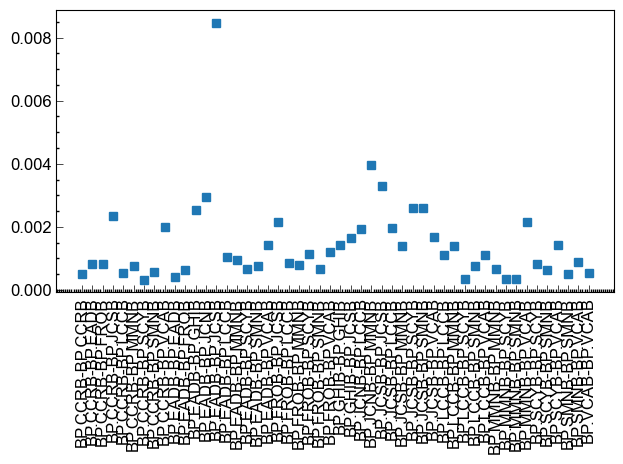

In [55]:
# plt.plot(df_dvvstats_all.residu_absmean, "o")
plt.plot(df_dvvstats_all.residu_var, "s")
plt.xticks(rotation = 90);
plt.tight_layout()

## Plot all the dvv model fit

We sort ACF by the station pair's name, and CCD by the variance.

In [56]:
# # separate ACF and CCF, and then sort them
# station_ACF=[]
# station_CCF=[]

# for st in stationpair_list:
#     st1, st2 = st.split("-")
#     if st1==st2:
#         station_ACF.append(st)
#     else:
#         station_CCF.append(st)
        
# station_ACF = np.sort(station_ACF)
# station_CCF = np.sort(station_CCF)
# NACF = len(station_ACF)
# NCCF = len(station_CCF)

In [57]:
if dvvmethod=="mwcs":
    # separate ACF
    station_ACF=[]
    for st in stationpair_list:
        st1, st2 = st.split("-")
        if st1==st2:
            station_ACF.append(st)

    station_ACF = np.sort(station_ACF)
    NACF = len(station_ACF)

    # CCF sorted by the variance
    station_CCF=[]
    for index, row in df_dvvstats_all.sort_values(by="residu_var", ascending=True).iterrows():
        st1, st2 = index.split("-")
        if st1 != st2:
            station_CCF.append(index)

    NCCF = len(station_CCF)

    # save the list of stations to synchronize with the stretching result
    stationpairs_dict={"station_ACF":station_ACF, "station_CCF":station_CCF}
    if dvvmethod=="mwcs":
        with open(outputdatadir+f'/plot_dvvmodel_listofstationpair_{freqband}_{modelcase}.pickle', 'wb') as fo:
            pickle.dump(stationpairs_dict, fo)
            
else:
    try:
        with open(outputdatadir+f'/plot_dvvmodel_listofstationpair_{freqband}_{modelcase}.pickle', 'rb') as fi:
            stationpairs_dict = pickle.load(fi)
    except:
        print('please run the mwcs first to dump the station list.')
    
    station_ACF = stationpairs_dict["station_ACF"]
    station_CCF = stationpairs_dict["station_CCF"]
    NACF = len(station_ACF)
    NCCF = len(station_CCF)


In [58]:
stationpairs_dict

{'station_ACF': array(['BP.CCRB-BP.CCRB', 'BP.EADB-BP.EADB', 'BP.GHIB-BP.GHIB',
        'BP.JCSB-BP.JCSB', 'BP.LCCB-BP.LCCB', 'BP.MMNB-BP.MMNB',
        'BP.SCYB-BP.SCYB', 'BP.SMNB-BP.SMNB', 'BP.VARB-BP.VARB',
        'BP.VCAB-BP.VCAB'], dtype='<U15'),
 'station_CCF': ['BP.CCRB-BP.SMNB',
  'BP.CCRB-BP.SCYB',
  'BP.SCYB-BP.SMNB',
  'BP.EADB-BP.MMNB',
  'BP.MMNB-BP.SCYB',
  'BP.CCRB-BP.LCCB',
  'BP.LCCB-BP.SMNB',
  'BP.MMNB-BP.SMNB',
  'BP.MMNB-BP.VCAB',
  'BP.LCCB-BP.SCYB',
  'BP.CCRB-BP.MMNB',
  'BP.SCYB-BP.VCAB',
  'BP.LCCB-BP.MMNB',
  'BP.EADB-BP.VCAB',
  'BP.CCRB-BP.VCAB',
  'BP.CCRB-BP.EADB',
  'BP.EADB-BP.LCCB',
  'BP.EADB-BP.SCYB',
  'BP.SMNB-BP.VCAB',
  'BP.LCCB-BP.VCAB',
  'BP.FROB-BP.MMNB',
  'BP.EADB-BP.SMNB',
  'BP.EADB-BP.GHIB',
  'BP.JCSB-BP.MMNB',
  'BP.EADB-BP.VARB',
  'BP.FROB-BP.GHIB',
  'BP.GHIB-BP.JCSB',
  'BP.JCSB-BP.LCCB',
  'BP.JCSB-BP.SCYB',
  'BP.LCCB-BP.VARB',
  'BP.SMNB-BP.VARB',
  'BP.JCSB-BP.VCAB',
  'BP.EADB-BP.JCSB',
  'BP.JCSB-BP.SMNB',
  'BP.FROB-BP.SCYB

In [59]:
NACF, NCCF

(10, 46)

/Users/kokubo/opt/miniconda3/envs/obspy3.8/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


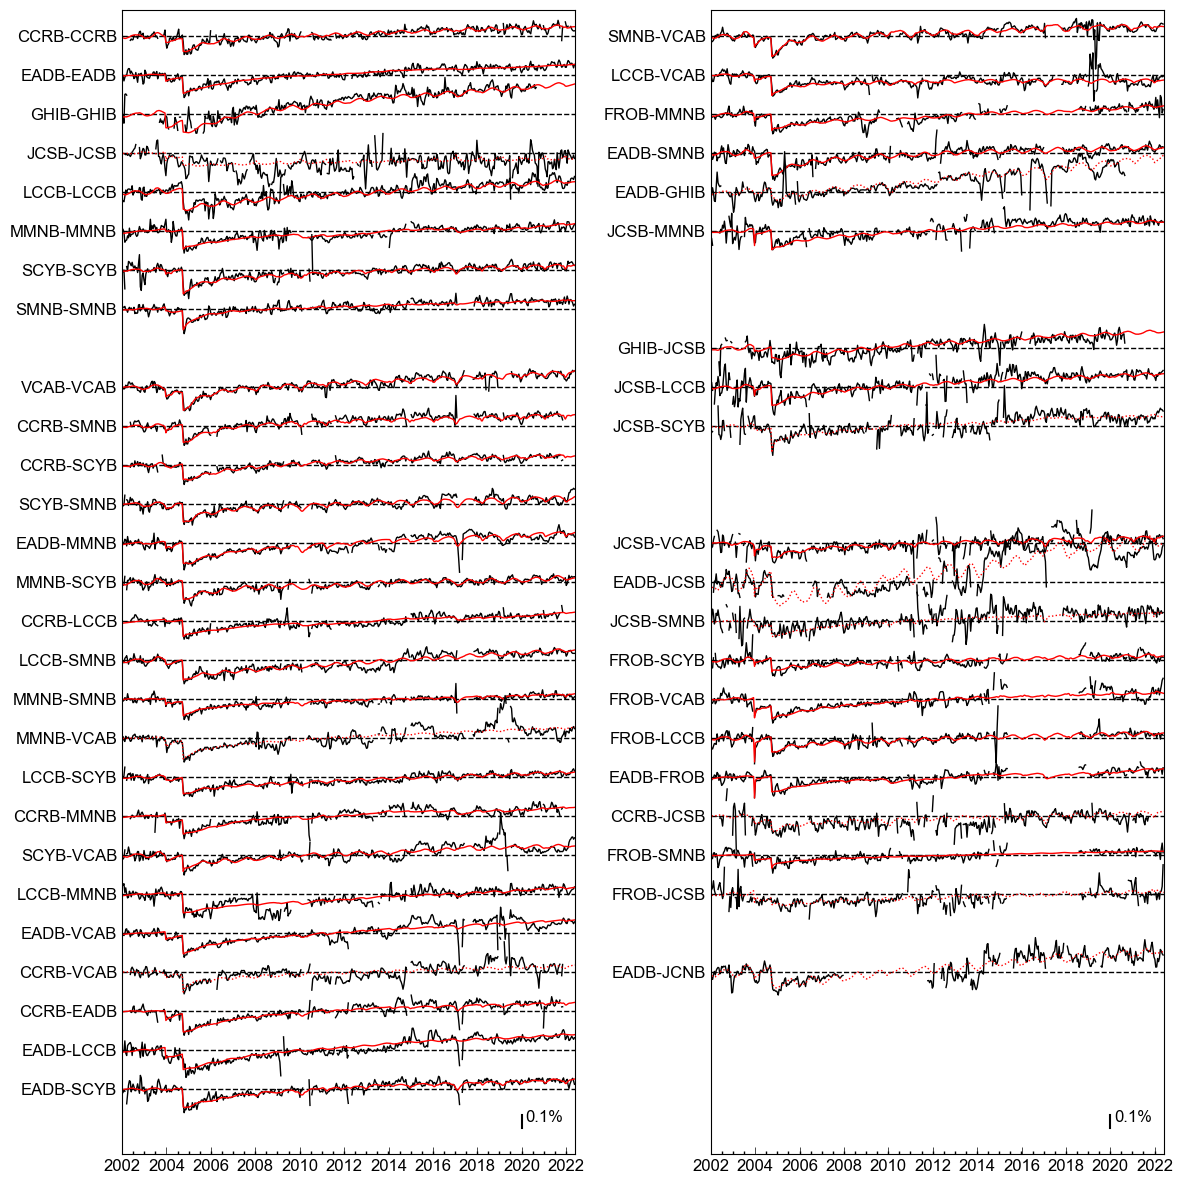

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(12,12))

dvvmodel_IsOffsetRemoval = True
shift_y = 0.3
tSS = datetime.datetime(2003, 12, 22) # time for San Simeon
offset_ind = np.where(np.array(meta_dict["uniform_tvec"]) < tSS)

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

#--------------------------------#
# First half pairs
#--------------------------------#

# plot ACF
label_yticks_1 = []
label_yticklabels_1 = []
for i, st in enumerate(station_ACF):
    try:
        dvv_data = dvv_dict[st+"/dvv_data"]
    except:
        continue
        
    dvv_model = dvv_dict[st+"/dvv_model"]

#     if df_dvvstats_all.loc[st].residu_absmean > residu_absmean_thresh:
    if df_dvvstats_all.loc[st].residu_var > residu_var_thresh:
        ls = ":"
    else:
        ls = "-"
    
    # remove offset
    if dvvmodel_IsOffsetRemoval:
        dvv_data = dvv_data - np.nanmean(dvv_data[offset_ind])    
        dvv_model = dvv_model - np.nanmean(dvv_model[offset_ind])    

    axs[0].plot(meta_dict["uniform_tvec"], dvv_data - i*shift_y, "k-", lw=1.0)
    axs[0].plot(meta_dict["uniform_tvec"], dvv_model - i*shift_y, "r", lw=1.0, ls=ls)
    axs[0].axhline(-i*shift_y, c="k", ls="--", lw=1.0, zorder=-10)

    label_yticks_1.append(- i*shift_y)
    # reformat the string
    netsta1, netsta2 = st.split("-")
    _, sta1 = netsta1.split('.')
    _, sta2 = netsta2.split('.')
    label_yticklabels_1.append(f"{sta1}-{sta2}")

# plot CCF
mNCCF = 28-NACF

for i, st in enumerate(station_CCF[:mNCCF]):
    try:
        dvv_data = dvv_dict[st+"/dvv_data"]
    except:
        continue;
        
    dvv_model = dvv_dict[st+"/dvv_model"]
    
#     if df_dvvstats_all.loc[st].residu_absmean > residu_absmean_thresh:
    if df_dvvstats_all.loc[st].residu_var > residu_var_thresh:

        ls = ":"
    else:
        ls = "-"
    
    # remove offset
    if dvvmodel_IsOffsetRemoval:
        dvv_data = dvv_data - np.nanmean(dvv_data[offset_ind])    
        dvv_model = dvv_model - np.nanmean(dvv_model[offset_ind])    

    axs[0].plot(meta_dict["uniform_tvec"], dvv_data - (i+NACF)*shift_y, "k-", lw=1.0)
    axs[0].plot(meta_dict["uniform_tvec"], dvv_model - (i+NACF)*shift_y, "r", lw=1.0,  ls=ls)
    axs[0].axhline(-(i+NACF)*shift_y, c="k", ls="--", lw=1.0, zorder=-10)

    label_yticks_1.append(-(i+NACF)*shift_y)
    # reformat the string
    netsta1, netsta2 = st.split("-")
    _, sta1 = netsta1.split('.')
    _, sta2 = netsta2.split('.')
    label_yticklabels_1.append(f"{sta1}-{sta2}")

#--------------------------------#
# second half pairs
#--------------------------------#
label_yticks_2 = []
label_yticklabels_2 = []
for i, st in enumerate(station_CCF[mNCCF:]):
    try:
        dvv_data = dvv_dict[st+"/dvv_data"]
    except:
        continue;
        
    dvv_model = dvv_dict[st+"/dvv_model"]
    
#     if df_dvvstats_all.loc[st].residu_absmean > residu_absmean_thresh:
    if df_dvvstats_all.loc[st].residu_var > residu_var_thresh:
        ls = ":"
    else:
        ls = "-"
    
    # remove offset
    if dvvmodel_IsOffsetRemoval:
        dvv_data = dvv_data - np.nanmean(dvv_data[offset_ind])    
        dvv_model = dvv_model - np.nanmean(dvv_model[offset_ind])    

    axs[1].plot(meta_dict["uniform_tvec"], dvv_data - (i+0)*shift_y, "k-", lw=1.0)
    axs[1].plot(meta_dict["uniform_tvec"], dvv_model - (i+0)*shift_y, "r", lw=1.0, ls=ls)
    axs[1].axhline(-(i+0)*shift_y, c="k", ls="--", lw=1.0, zorder=-10)

    label_yticks_2.append(-(i+0)*shift_y)
    # reformat the string
    netsta1, netsta2 = st.split("-")
    _, sta1 = netsta1.split('.')
    _, sta2 = netsta2.split('.')
    label_yticklabels_2.append(f"{sta1}-{sta2}")


axs[0].set_yticks(label_yticks_1)
axs[0].set_yticklabels(label_yticklabels_1)
axs[0].set_xlim(starttime, endtime)
axs[0].set_ylim([-8.6, 0.2])

axs[1].set_yticks(label_yticks_2)
axs[1].set_yticklabels(label_yticklabels_2)
axs[1].set_xlim(starttime, endtime)
axs[1].set_ylim([-8.6, 0.2])


fig.tight_layout()
fig.align_labels();


# plot scale
scale_x=datetime.datetime(2020,1,1)
scale_y = -8.4
scale_size = 0.1 #[%]

for i in range(2):
    axs[i].plot([scale_x, scale_x], [scale_y, scale_y + scale_size], ls ="-", c="k" )
    axs[i].text(scale_x+datetime.timedelta(days=60), scale_y + 0.5*scale_size, f"{scale_size}%", c="k" )


foname = (output_imgdir+"/MCMC_alldvvfit_{}_{}_{}.png".format(dvvmethod, freqband, modelcase))
plt.savefig(foname, dpi=300)